# Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization

### MNIST to SVHN

References:

Advanced Deep Learning with TensorFlow 2 and Keras by Rowel Atienza, Chapter 7: Cross-Domain GANs

### General Utilities

In [1]:
"""General utilities for displaying and loading data, RGB 
   to gray function, and testing source/target generators
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import os
import math

def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale
       Reference: opencv.org
       Formula: grayscale = 0.299*red + 0.587*green + 0.114*blue
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def display_images(imgs,
                   filename,
                   title='',
                   imgs_dir=None,
                   show=False):
    """Display images in an nxn grid

    Arguments:
    imgs (tensor): array of images
    filename (string): filename to save the displayed image
    title (string): title on the displayed image
    imgs_dir (string): directory where to save the files
    show (bool): whether to display the image or not 
          (False during training, True during testing)

    """

    rows = imgs.shape[1]
    cols = imgs.shape[2]
    channels = imgs.shape[3]
    side = int(math.sqrt(imgs.shape[0]))
    assert int(side * side) == imgs.shape[0]

    # create saved_images folder
    if imgs_dir is None:
        imgs_dir = 'saved_images'
    save_dir = os.path.join(os.getcwd(), imgs_dir)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filename = os.path.join(imgs_dir, filename)
    # rows, cols, channels = img_shape
    if channels==1:
        imgs = imgs.reshape((side, side, rows, cols))
    else:
        imgs = imgs.reshape((side, side, rows, cols, channels))
    imgs = np.vstack([np.hstack(i) for i in imgs])
    plt.figure()
    plt.axis('off')
    plt.title(title)
    if channels==1:
        plt.imshow(imgs, interpolation='none', cmap='gray')
    else:
        plt.imshow(imgs, interpolation='none')
    plt.savefig(filename)
    if show:
        plt.show()
    
    plt.close('all')


def test_generator_utility(generators,
                   test_data,
                   step,
                   titles,
                   dirs,
                   todisplay=100,
                   show=False):
    """Test the generator models

    Arguments:
    generators (tuple): source and target generators
    test_data (tuple): source and target test data
    step (int): step number during training (0 during testing)
    titles (tuple): titles on the displayed image
    dirs (tuple): folders to save the outputs of testings
    todisplay (int): number of images to display (must be
        perfect square)
    show (bool): whether to display the image or not 
          (False during training, True during testing)

    """


    # predict the output from test data
    g_source, g_target = generators
    test_source_data, test_target_data = test_data
    t1, t2, t3, t4 = titles
    title_pred_source = t1
    title_pred_target = t2
    title_reco_source = t3
    title_reco_target = t4
    dir_pred_source, dir_pred_target = dirs

    pred_target_data = g_target.predict(test_source_data)
    pred_source_data = g_source.predict(test_target_data)
    reco_source_data = g_source.predict(pred_target_data)
    reco_target_data = g_target.predict(pred_source_data)

    # display the 1st todisplay images
    imgs = pred_target_data[:todisplay]
    filename = '%06d.png' % step
    step = " Step: {:,}".format(step)
    title = title_pred_target + step
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                   show=show)

    imgs = pred_source_data[:todisplay]
    title = title_pred_source
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_source_data[:todisplay]
    title = title_reco_source
    filename = "reconstructed_source.png"
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_target_data[:todisplay]
    title = title_reco_target
    filename = "reconstructed_target.png"
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                   show=show)


def load_data_utility(data, titles, filenames, todisplay=100):
    """Generic loaded data transformation

    Arguments:
    data (tuple): source, target, test source, test target data
    titles (tuple): titles of the test and source images to display
    filenames (tuple): filenames of the test and source images to
       display
    todisplay (int): number of images to display (must be
        perfect square)

    """

    source_data, target_data, test_source_data, test_target_data = data
    test_source_filename, test_target_filename = filenames
    test_source_title, test_target_title = titles

    # display test target images
    imgs = test_target_data[:todisplay]
    display_images(imgs,
                   filename=test_target_filename,
                   title=test_target_title)

    # display test source images
    imgs = test_source_data[:todisplay]
    display_images(imgs,
                   filename=test_source_filename,
                   title=test_source_title)

    # normalize images
    target_data = target_data.astype('float32')  / 255
    test_target_data = test_target_data.astype('float32') / 255

    source_data = source_data.astype('float32')  / 255
    test_source_data = test_source_data.astype('float32') / 255

    # source data, target data, test_source data
    data = (source_data, target_data, test_source_data, test_target_data)

    rows = source_data.shape[1]
    cols = source_data.shape[2]
    channels = source_data.shape[3]
    source_shape = (rows, cols, channels)

    rows = target_data.shape[1]
    cols = target_data.shape[2]
    channels = target_data.shape[3]
    target_shape = (rows, cols, channels)

    shapes = (source_shape, target_shape)
    
    return data, shapes


### MNIST SVHN Utilities

In [2]:
"""Utilities for loading MNIST and SVHN

Street View House Number (SVHN) dataset:
http://ufldl.stanford.edu/housenumbers/

Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, 
Bo Wu, Andrew Y. Ng Reading Digits in Natural Images with 
Unsupervised Feature Learning NIPS Workshop on Deep Learning 
and Unsupervised Feature Learning 2011. (PDF)


"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import get_file

import numpy as np
from scipy import io
#import other_utils
import os


def get_datadir():
    cache_dir = os.path.join(os.path.expanduser('~'), '.keras')
    cache_subdir = 'datasets'
    datadir_base = os.path.expanduser(cache_dir)
    if not os.access(datadir_base, os.W_OK):
        datadir_base = os.path.join('/tmp', '.keras')

    datadir = os.path.join(datadir_base, cache_subdir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    return datadir


def mnist_svhn_load_data():
    # load mnist data
    (source_data, _), (test_source_data, _) = mnist.load_data()

    # pad with zeros 28x28 MNIST image to become 32x32
    # svhn is 32x32
    source_data = np.pad(source_data,
                         ((0,0), (2,2), (2,2)),
                         'constant',
                         constant_values=0)
    test_source_data = np.pad(test_source_data,
                              ((0,0), (2,2), (2,2)),
                              'constant',
                              constant_values=0)
    # input image dimensions
    # we assume data format "channels_last"
    rows = source_data.shape[1]
    cols = source_data.shape[2]
    channels = 1

    # reshape images to row x col x channels
    # for CNN output/validation
    size = source_data.shape[0]
    source_data = source_data.reshape(size,
                                      rows,
                                      cols,
                                      channels)
    size = test_source_data.shape[0]
    test_source_data = test_source_data.reshape(size,
                                                rows,
                                                cols,
                                                channels)

    # load SVHN data
    datadir = get_datadir()
    get_file('train_32x32.mat',
             origin='http://ufldl.stanford.edu/housenumbers/train_32x32.mat')
    get_file('test_32x32.mat',
             'http://ufldl.stanford.edu/housenumbers/test_32x32.mat')
    path = os.path.join(datadir, 'train_32x32.mat')
    target_data = loadmat(path)
    path = os.path.join(datadir, 'test_32x32.mat')
    test_target_data = loadmat(path)

    # source data, target data, test_source data
    data = (source_data, target_data, test_source_data, test_target_data)
    filenames = ('mnist_test_source.png', 'svhn_test_target.png')
    titles = ('MNIST test source images', 'SVHN test target images')
    
    return load_data_utility(data, titles, filenames)


def loadmat(filename):
    # load SVHN dataset
    mat = io.loadmat(filename)
    # the key to image data is 'X', the image label key is 'y'
    data = mat['X']
    rows =data.shape[0]
    cols = data.shape[1]
    channels = data.shape[2]
    # in matlab data, the image index is the last index
    # in keras, the image index is the first index so
    # perform transpose for the last index
    data = np.transpose(data, (3, 0, 1, 2))
    return data


### Adaptive Instance Normalization

First implementation

In [3]:
import keras
import keras.backend as K

class AdaptiveInstanceNorm(keras.layers.Layer):
    def __init__(self, epsilon=1e-3):
        super(AdaptiveInstanceNorm, self).__init__()
        self.epsilon = epsilon


    def call(self, inputs):
        x, style = inputs
        axis = [1, 2]
        x_mean = K.mean(x, axis=axis, keepdims=True)
        x_std = K.std(x, axis=axis, keepdims=True)

        style_mean = K.mean(style, axis=axis, keepdims=True)
        style_std = K.std(style, axis=axis, keepdims=True)

        norm = (x - x_mean) * (1 / (x_std + self.epsilon))

        return norm * (style_std + self.epsilon) + style_mean


    def compute_output_shape(self, input_shape):
        return input_shape[0]

A second implementation of Adaptive Instance Normalization

In [4]:
import tensorflow as tf


def AdaIN(content, style, epsilon=1e-5):
    meanC, varC = tf.nn.moments(content, [1, 2], keep_dims=True)
    meanS, varS = tf.nn.moments(style,   [1, 2], keep_dims=True)

    sigmaC = tf.sqrt(tf.add(varC, epsilon))
    sigmaS = tf.sqrt(tf.add(varS, epsilon))
    
    return (content - meanC) * sigmaS / sigmaC + meanS

Will be used in the encoder_layer function below

### Cycle GAN

In [8]:
"""Builds and trains a CycleGAN

CycleGAN is a cross-domain GAN. Like other GANs, it can be trained
in unsupervised manner.

CycleGAN is made of two generators (G & F) and two discriminators.
Each generator is a U-Network. The discriminator is a 
typical decoder network with the option to use PatchGAN structure.

There are 2 datasets: x = source, y = target. 
The forward-cycle solves x'= F(y') = F(G(x)) where y' is 
the predicted output in y-domain and x' is the reconstructed input.
The target discriminator determines if y' is fake/real. 
The objective of the forward-cycle generator G is to learn 
how to trick the target discriminator into believing that y'
is real.

The backward-cycle improves the performance of CycleGAN by doing 
the opposite of forward cycle. It learns how to solve
y' = G(x') = G(F(y)) where x' is the predicted output in the
x-domain. The source discriminator determines if x' is fake/real.
The objective of the backward-cycle generator F is to learn 
how to trick the target discriminator into believing that x' 
is real.

References:
[1]Zhu, Jun-Yan, et al. "Unpaired Image-to-Image Translation Using
Cycle-Consistent Adversarial Networks." 2017 IEEE International
Conference on Computer Vision (ICCV). IEEE, 2017.

[2]Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net:
Convolutional networks for biomedical image segmentation."
International Conference on Medical image computing and
computer-assisted intervention. Springer, Cham, 2015.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

# from keras_contrib.layers.normalization import InstanceNormalization
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# install: pip install tensorflow-addons
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import argparse
#import cifar10_utils
#import mnist_svhn_utils
#import other_utils
import datetime


def encoder_layer(inputs,
                  filters=16,
                  kernel_size=3,
                  strides=2,
                  activation='relu',
                  instance_norm=True):
    """Builds a generic encoder layer made of Conv2D-IN-LeakyReLU
       IN is optional, LeakyReLU may be replaced by ReLU
    """

    conv = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same')

    x = inputs
    
    if instance_norm:
        use_adain = False  # Set to True to use Adaptive Instance Normalization.
        
        if use_adain:
            # Unfortunately, I have not been able to successfully integrate this
            # AdaptiveInstanceNorm() with the encoder layer. I'm getting the
            # following error:
            # OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not
            # allowed in Graph execution. Use Eager execution or decorate this
            # function with @tf.function.
            # Any feedback on what I'm doing wrong would be greatly appreciated
            # since my ultimate goal is to learn something I can use in future
            # work. Thanks in advance.
            x = AdaptiveInstanceNorm()(x)
        else:
            x = InstanceNormalization()(x)

    if activation == 'relu':
        x = Activation('relu')(x)
    else:
        x = LeakyReLU(alpha=0.2)(x)
    
    x = conv(x)
    
    return x


def decoder_layer(inputs,
                  paired_inputs,
                  filters=16,
                  kernel_size=3,
                  strides=2,
                  activation='relu',
                  instance_norm=True):
    """Builds a generic decoder layer made of Conv2D-IN-LeakyReLU
    IN is optional, LeakyReLU may be replaced by ReLU
    Arguments: (partial)
    inputs (tensor): the decoder layer input
    paired_inputs (tensor): the encoder layer output 
          provided by U-Net skip connection &
          concatenated to inputs.
    """

    conv = Conv2DTranspose(filters=filters,
                           kernel_size=kernel_size,
                           strides=strides,
                           padding='same')

    x = inputs
    if instance_norm:
        x = InstanceNormalization()(x)
    if activation == 'relu':
        x = Activation('relu')(x)
    else:
        x = LeakyReLU(alpha=0.2)(x)
    x = conv(x)
    x = concatenate([x, paired_inputs])
    return x


def build_generator(input_shape,
                    output_shape=None,
                    kernel_size=3,
                    name=None):
    """The generator is a U-Network made of a 4-layer encoder
    and a 4-layer decoder. Layer n-i is connected to layer i.

    Arguments:
    input_shape (tuple): input shape
    output_shape (tuple): output shape
    kernel_size (int): kernel size of encoder & decoder layers
    name (string): name assigned to generator model

    Returns:
    generator (Model):

    """

    inputs = Input(shape=input_shape)
    channels = int(output_shape[-1])
    e1 = encoder_layer(inputs,
                       32,
                       kernel_size=kernel_size,
                       activation='leaky_relu',
                       strides=1)
    e2 = encoder_layer(e1,
                       64,
                       activation='leaky_relu',
                       kernel_size=kernel_size)
    e3 = encoder_layer(e2,
                       128,
                       activation='leaky_relu',
                       kernel_size=kernel_size)
    e4 = encoder_layer(e3,
                       256,
                       activation='leaky_relu',
                       kernel_size=kernel_size)

    d1 = decoder_layer(e4,
                       e3,
                       128,
                       kernel_size=kernel_size)
    d2 = decoder_layer(d1,
                       e2,
                       64,
                       kernel_size=kernel_size)
    d3 = decoder_layer(d2,
                       e1,
                       32,
                       kernel_size=kernel_size)
    outputs = Conv2DTranspose(channels,
                              kernel_size=kernel_size,
                              strides=1,
                              activation='sigmoid',
                              padding='same')(d3)

    generator = Model(inputs, outputs, name=name)

    return generator


def build_discriminator(input_shape,
                        kernel_size=3,
                        patchgan=True,
                        name=None):
    """The discriminator is a 4-layer encoder that outputs either
    a 1-dim or a n x n-dim patch of probability that input is real 

    Arguments:
    input_shape (tuple): input shape
    kernel_size (int): kernel size of decoder layers
    patchgan (bool): whether the output is a patch 
        or just a 1-dim
    name (string): name assigned to discriminator model

    Returns:
    discriminator (Model):

    """

    inputs = Input(shape=input_shape)
    x = encoder_layer(inputs,
                      32,
                      kernel_size=kernel_size,
                      activation='leaky_relu',
                      instance_norm=False)
    x = encoder_layer(x,
                      64,
                      kernel_size=kernel_size,
                      activation='leaky_relu',
                      instance_norm=False)
    x = encoder_layer(x,
                      128,
                      kernel_size=kernel_size,
                      activation='leaky_relu',
                      instance_norm=False)
    x = encoder_layer(x,
                      256,
                      kernel_size=kernel_size,
                      strides=1,
                      activation='leaky_relu',
                      instance_norm=False)

    # if patchgan=True use nxn-dim output of probability
    # else use 1-dim output of probability
    if patchgan:
        x = LeakyReLU(alpha=0.2)(x)
        outputs = Conv2D(1,
                         kernel_size=kernel_size,
                         strides=2,
                         padding='same')(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)
        outputs = Activation('linear')(x)


    discriminator = Model(inputs, outputs, name=name)

    return discriminator


def train_cyclegan(models,
                   data,
                   params,
                   test_params, 
                   test_generator):
    """ Trains the CycleGAN. 
    
    1) Train the target discriminator
    2) Train the source discriminator
    3) Train the forward and backward cyles of 
        adversarial networks

    Arguments:
    models (Models): Source/Target Discriminator/Generator,
        Adversarial Model
    data (tuple): source and target training data
    params (tuple): network parameters
    test_params (tuple): test parameters
    test_generator (function): used for generating 
        predicted target and source images
    """

    # the models
    g_source, g_target, d_source, d_target, adv = models
    # network parameters
    batch_size, train_steps, patch, model_name = params
    # train dataset
    source_data, target_data, test_source_data, test_target_data\
            = data

    titles, dirs = test_params

    # the generator image is saved every 2000 steps
    save_interval = 2000
    target_size = target_data.shape[0]
    source_size = source_data.shape[0]

    # whether to use patchgan or not
    if patch > 1:
        d_patch = (patch, patch, 1)
        valid = np.ones((batch_size,) + d_patch)
        fake = np.zeros((batch_size,) + d_patch)
    else:
        valid = np.ones([batch_size, 1])
        fake = np.zeros([batch_size, 1])

    valid_fake = np.concatenate((valid, fake))
    start_time = datetime.datetime.now()

    for step in range(train_steps):
        # sample a batch of real target data
        rand_indexes = np.random.randint(0, 
                                         target_size,
                                         size=batch_size)
        real_target = target_data[rand_indexes]

        # sample a batch of real source data
        rand_indexes = np.random.randint(0, 
                                         source_size,
                                         size=batch_size)
        real_source = source_data[rand_indexes]
        # generate a batch of fake target data fr real source data
        fake_target = g_target.predict(real_source)
        
        # combine real and fake into one batch
        x = np.concatenate((real_target, fake_target))
        # train the target discriminator using fake/real data
        metrics = d_target.train_on_batch(x, valid_fake)
        log = "%d: [d_target loss: %f]" % (step, metrics[0])

        # generate a batch of fake source data fr real target data
        fake_source = g_source.predict(real_target)
        x = np.concatenate((real_source, fake_source))
        # train the source discriminator using fake/real data
        metrics = d_source.train_on_batch(x, valid_fake)
        log = "%s [d_source loss: %f]" % (log, metrics[0])

        # train the adversarial network using forward and backward
        # cycles. the generated fake source and target 
        # data attempts to trick the discriminators
        x = [real_source, real_target]
        y = [valid, valid, real_source, real_target]
        metrics = adv.train_on_batch(x, y)
        elapsed_time = datetime.datetime.now() - start_time
        fmt = "%s [adv loss: %f] [time: %s]"
        log = fmt % (log, metrics[0], elapsed_time)
        print(log)
        if (step + 1) % save_interval == 0:
            test_generator((g_source, g_target),
                           (test_source_data, test_target_data),
                           step=step+1,
                           titles=titles,
                           dirs=dirs,
                           show=False)

    # save the models after training the generators
    g_source.save(model_name + "-g_source.h5")
    g_target.save(model_name + "-g_target.h5")


def build_cyclegan(shapes,
                   source_name='source',
                   target_name='target',
                   kernel_size=3,
                   patchgan=False,
                   identity=False
                   ):
    """Build the CycleGAN

    1) Build target and source discriminators
    2) Build target and source generators
    3) Build the adversarial network

    Arguments:
    shapes (tuple): source and target shapes
    source_name (string): string to be appended on dis/gen models
    target_name (string): string to be appended on dis/gen models
    kernel_size (int): kernel size for the encoder/decoder
        or dis/gen models
    patchgan (bool): whether to use patchgan on discriminator
    identity (bool): whether to use identity loss

    Returns:
    (list): 2 generator, 2 discriminator, 
        and 1 adversarial models 

    """

    source_shape, target_shape = shapes
    lr = 2e-4
    decay = 6e-8
    gt_name = "gen_" + target_name
    gs_name = "gen_" + source_name
    dt_name = "dis_" + target_name
    ds_name = "dis_" + source_name

    # build target and source generators
    g_target = build_generator(source_shape,
                               target_shape,
                               kernel_size=kernel_size,
                               name=gt_name)
    g_source = build_generator(target_shape,
                               source_shape,
                               kernel_size=kernel_size,
                               name=gs_name)
    print('---- TARGET GENERATOR ----')
    g_target.summary()
    print('---- SOURCE GENERATOR ----')
    g_source.summary()

    # build target and source discriminators
    d_target = build_discriminator(target_shape,
                                   patchgan=patchgan,
                                   kernel_size=kernel_size,
                                   name=dt_name)
    d_source = build_discriminator(source_shape,
                                   patchgan=patchgan,
                                   kernel_size=kernel_size,
                                   name=ds_name)
    print('---- TARGET DISCRIMINATOR ----')
    d_target.summary()
    print('---- SOURCE DISCRIMINATOR ----')
    d_source.summary()

    optimizer = RMSprop(lr=lr, decay=decay)
    d_target.compile(loss='mse',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    d_source.compile(loss='mse',
                     optimizer=optimizer,
                     metrics=['accuracy'])

    d_target.trainable = False
    d_source.trainable = False

    # build the computational graph for the adversarial model
    # forward cycle network and target discriminator
    source_input = Input(shape=source_shape)
    fake_target = g_target(source_input)
    preal_target = d_target(fake_target)
    reco_source = g_source(fake_target)

    # backward cycle network and source discriminator
    target_input = Input(shape=target_shape)
    fake_source = g_source(target_input)
    preal_source = d_source(fake_source)
    reco_target = g_target(fake_source)

    # if we use identity loss, add 2 extra loss terms
    # and outputs
    if identity:
        iden_source = g_source(source_input)
        iden_target = g_target(target_input)
        loss = ['mse', 'mse', 'mae', 'mae', 'mae', 'mae']
        loss_weights = [1., 1., 10., 10., 0.5, 0.5]
        inputs = [source_input, target_input]
        outputs = [preal_source,
                   preal_target,
                   reco_source,
                   reco_target,
                   iden_source,
                   iden_target]
    else:
        loss = ['mse', 'mse', 'mae', 'mae']
        loss_weights = [1., 1., 10., 10.]
        inputs = [source_input, target_input]
        outputs = [preal_source,
                   preal_target,
                   reco_source,
                   reco_target]

    # build adversarial model
    adv = Model(inputs, outputs, name='adversarial')
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    adv.compile(loss=loss,
                loss_weights=loss_weights,
                optimizer=optimizer,
                metrics=['accuracy'])
    print('---- ADVERSARIAL NETWORK ----')
    adv.summary()

    return g_source, g_target, d_source, d_target, adv


def mnist_cross_svhn(g_models=None):
    """Build and train a CycleGAN that can do mnist <--> svhn
    """

    model_name = 'cyclegan_mnist_svhn'
    batch_size = 32
    train_steps = 1000 # Increase to 100000 for better results.
    patchgan = True
    kernel_size = 5
    postfix = ('%dp' % kernel_size) \
            if patchgan else ('%d' % kernel_size)

    data, shapes = mnist_svhn_load_data()
    source_data, _, test_source_data, test_target_data = data
    titles = ('MNIST predicted source images.',
              'SVHN predicted target images.',
              'MNIST reconstructed source images.',
              'SVHN reconstructed target images.')
    dirs = ('mnist_source-%s' \
            % postfix, 'svhn_target-%s' % postfix)

    # generate predicted target(svhn) and source(mnist) images
    if g_models is not None:
        g_source, g_target = g_models
        test_generator_utility((g_source, g_target),
                                   (test_source_data, \
                                           test_target_data),
                                   step=0,
                                   titles=titles,
                                   dirs=dirs,
                                   show=True)
        return

    # build the cyclegan for mnist cross svhn
    models = build_cyclegan(shapes,
                            "mnist-%s" % postfix,
                            "svhn-%s" % postfix,
                            kernel_size=kernel_size,
                            patchgan=patchgan)
    # patch size is divided by 2^n since we downscaled the input
    # in the discriminator by 2^n (ie. we use strides=2 n times)
    patch = int(source_data.shape[1] / 2**4) if patchgan else 1
    params = (batch_size, train_steps, patch, model_name)
    test_params = (titles, dirs)
    # train the cyclegan
    train_cyclegan(models,
                   data,
                   params,
                   test_params,
                   test_generator_utility)


### Train the CycleGAN for MNIST to SVHN

In [9]:
mnist_cross_svhn()

---- TARGET GENERATOR ----
Model: "gen_svhn-5p"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 32, 32, 1)    2           input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 1)    0           instance_normalization[0][0]     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   832         leaky_re_lu[0][0]                
_____________________________________________________________

### Use pre-trained models of CycleGAN with PatchGAN to perform the image translation

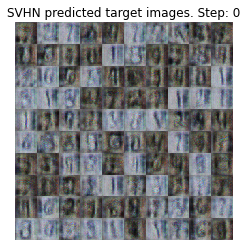

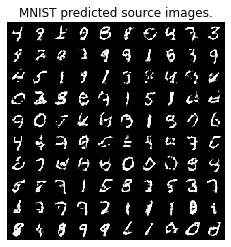

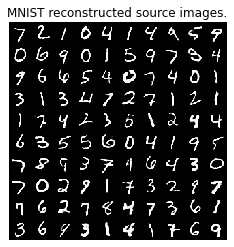

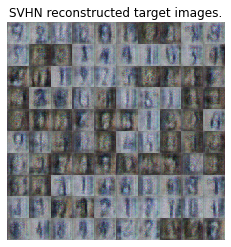

In [10]:
g_source = load_model('cyclegan_mnist_svhn-g_source.h5')
g_target = load_model('cyclegan_mnist_svhn-g_target.h5')
g_models = (g_source, g_target)
mnist_cross_svhn(g_models)